### Prepare the dataset and DataLoader

In [1]:
# setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# get training dataset
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# get testing dataset
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15132394.77it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 259967.33it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4963989.80it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1262189.57it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



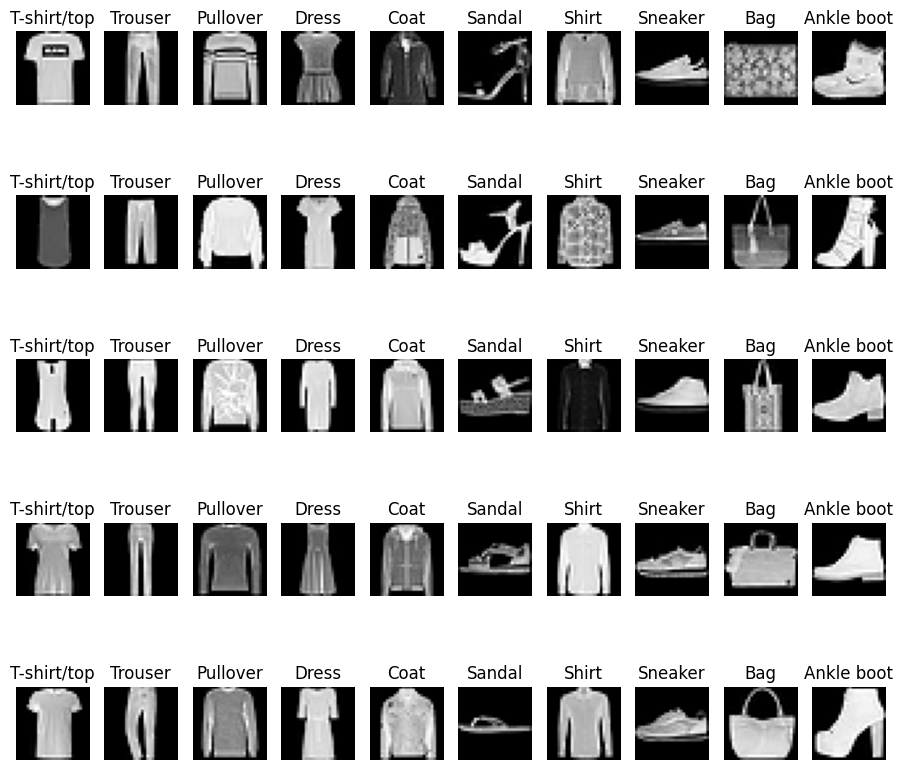

In [3]:
# visualize the data
import matplotlib.pyplot as plt
import random

class_names = train_data.classes

num_rows = 5 # display 5 images from each class
num_cols = len(class_names)

plt.figure(figsize=(9, 9))

for i in range(num_cols):
    idx = (train_data.targets == i) # get index of the samples which label == i (actually it will return a 1D tensor of values of True and False)
    display_img = train_data.data[idx][:num_rows] # only take the first num_rows samples
    display_label = train_data.targets[idx][:num_rows] # only take the first num_rows samples

    for j, (X, y) in enumerate(zip(display_img, display_label)):
        plt.subplot(num_rows, num_cols, j * num_cols + i + 1)
        plt.imshow(X.squeeze(), cmap="gray")
        plt.title(class_names[y])
        plt.axis(False)

    plt.tight_layout()

In [4]:
# visualize class distribution in the training dataset
label_distribution = torch.bincount(train_data.targets)
print("Distribution of labels\n")
for name, count in zip(class_names, label_distribution):
    print(f"{name}: {count}")

# we can see the dataset is uniformly distributed

Distribution of labels

T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


In [5]:
# prepare the DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# prepare training DataLoader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# prepare testing DataLoader
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [6]:
# confirm the shape
imgs, labels = next(iter(train_dataloader))
imgs.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### Build a CNN model

In [66]:
# for this part, I replicated the model shown in here https://poloclub.github.io/cnn-explainer/ for the feature learning part with slight modifications
from torch import nn

class ClassificationModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                        out_channels=10,
                        stride=1,
                        kernel_size=3,
                        padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=10,
                        out_channels=10,
                        stride=1,
                        kernel_size=3,
                        padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=10,
                        out_channels=15,
                        stride=1,
                        kernel_size=3,
                        padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=15,
                        out_channels=15,
                        stride=1,
                        kernel_size=3,
                        padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.MLP = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 15 * 7 * 7, # 28/2/2 = 7
                      out_features = num_classes)
        )

    def forward(self, X: torch.Tensor):
        y = self.feature_extractor(X)
        y = self.MLP(y)
        return y

In [67]:
# instantiate the model
from torchsummary import summary

model = ClassificationModel(in_channels=1, num_classes=len(class_names)).to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 15, 14, 14]           1,365
              ReLU-7           [-1, 15, 14, 14]               0
            Conv2d-8           [-1, 15, 14, 14]           2,040
              ReLU-9           [-1, 15, 14, 14]               0
        MaxPool2d-10             [-1, 15, 7, 7]               0
          Flatten-11                  [-1, 735]               0
           Linear-12                   [-1, 10]           7,360
Total params: 11,775
Trainable params: 11,775
Non-trainable params: 0
---------------------------------

### Define loss function and optimizer

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    return torch.sum(y_true == y_pred) / len(y_true)

### Train the model

In [69]:
# define training step
def train_model(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                optimizer: torch.optim.Optimizer,
                device: torch.device):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # get output logits
        y_logits = model(X)

        # calculate loss and accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_logits.argmax(dim=1)) # not using nn.Softmax to save one computation step, as the result is the same

        # optimizer zero grad
        optimizer.zero_grad()

        # back propagation
        loss.backward()

        # update weights
        optimizer.step()

        # print progress
        if batch % 400 == 0:
            print(f"Trained on {batch * len(X)}/{len(dataloader) * len(X)} samples")

    train_loss /= len(dataloader) # loss per batch
    train_acc /= len(dataloader) # accuracy per batch
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc * 100:.2f}%")

    return train_loss.item(), train_acc.item()

In [70]:
# define testing step
def test_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # get output logits
            y_logits = model(X)

            # calculate loss
            loss = loss_fn(y_logits, y)
            test_loss += loss
            test_acc += accuracy_fn(y, y_logits.argmax(dim=1)) # not using nn.Softmax to save one computation step, as the result is the same

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc * 100:.2f}%")

        return test_loss.item(), test_acc.item()

In [71]:
# start training the model
from tqdm.auto import tqdm

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"\n---Epoch {epoch + 1}/{epochs}---")
    # perform training
    train_loss, train_acc = train_model(model=model, dataloader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # perform testing
    test_loss, test_acc = test_model(model=model, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]


---Epoch 1/10---
Trained on 0/60000 samples
Trained on 12800/60000 samples
Trained on 25600/60000 samples
Trained on 38400/60000 samples
Trained on 51200/60000 samples
Train loss: 0.56464 | Train accuracy: 79.95%
Test loss: 0.36916 | Test accuracy: 87.02%

---Epoch 2/10---
Trained on 0/60000 samples
Trained on 12800/60000 samples
Trained on 25600/60000 samples
Trained on 38400/60000 samples
Trained on 51200/60000 samples
Train loss: 0.33352 | Train accuracy: 88.09%
Test loss: 0.35378 | Test accuracy: 87.02%

---Epoch 3/10---
Trained on 0/60000 samples
Trained on 12800/60000 samples
Trained on 25600/60000 samples
Trained on 38400/60000 samples
Trained on 51200/60000 samples
Train loss: 0.29747 | Train accuracy: 89.34%
Test loss: 0.31437 | Test accuracy: 88.65%

---Epoch 4/10---
Trained on 0/60000 samples
Trained on 12800/60000 samples
Trained on 25600/60000 samples
Trained on 38400/60000 samples
Trained on 51200/60000 samples
Train loss: 0.27768 | Train accuracy: 90.08%
Test loss: 0.30

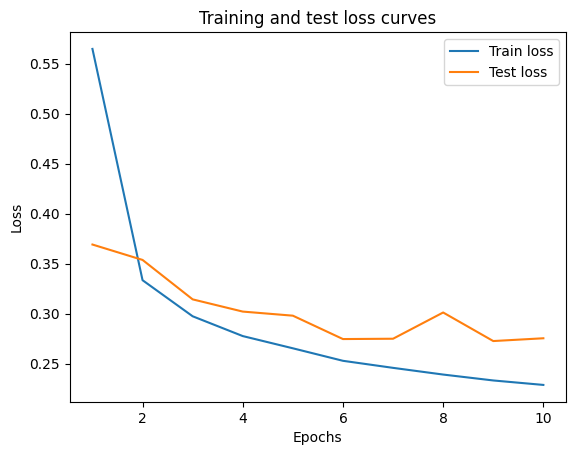

In [72]:
# track the learning performance
epoch_count = list(range(1, epochs + 1))
plt.plot(epoch_count, train_losses, label="Train loss")
plt.plot(epoch_count, test_losses, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

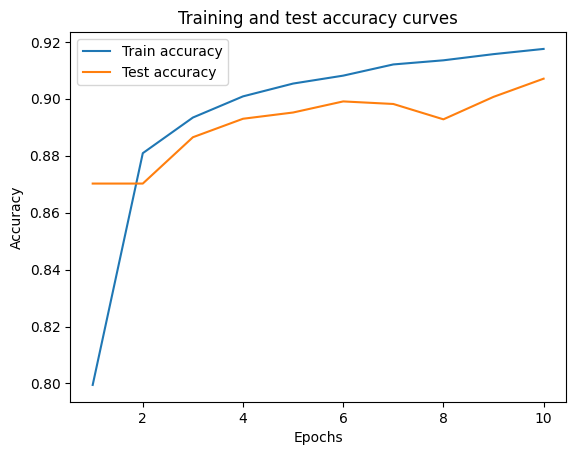

In [73]:
plt.plot(epoch_count, train_accuracies, label="Train accuracy")
plt.plot(epoch_count, test_accuracies, label="Test accuracy")
plt.title("Training and test accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

### Evaluate model performance

In [94]:
def inference(model: torch.nn.Module, X: torch.Tensor):
    X = X.to(device)

    model.eval()

    with torch.inference_mode():
        y_logits = model(X)

    return y_logits.argmax().item()

In [80]:
# prepare testing data
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=25):
    test_samples.append(sample)
    test_labels.append(label)

25

In [97]:
# do prediction
pred_labels = []
for X in test_samples:
    y_pred = inference(model, X.unsqueeze(dim=0))
    pred_labels.append(y_pred)

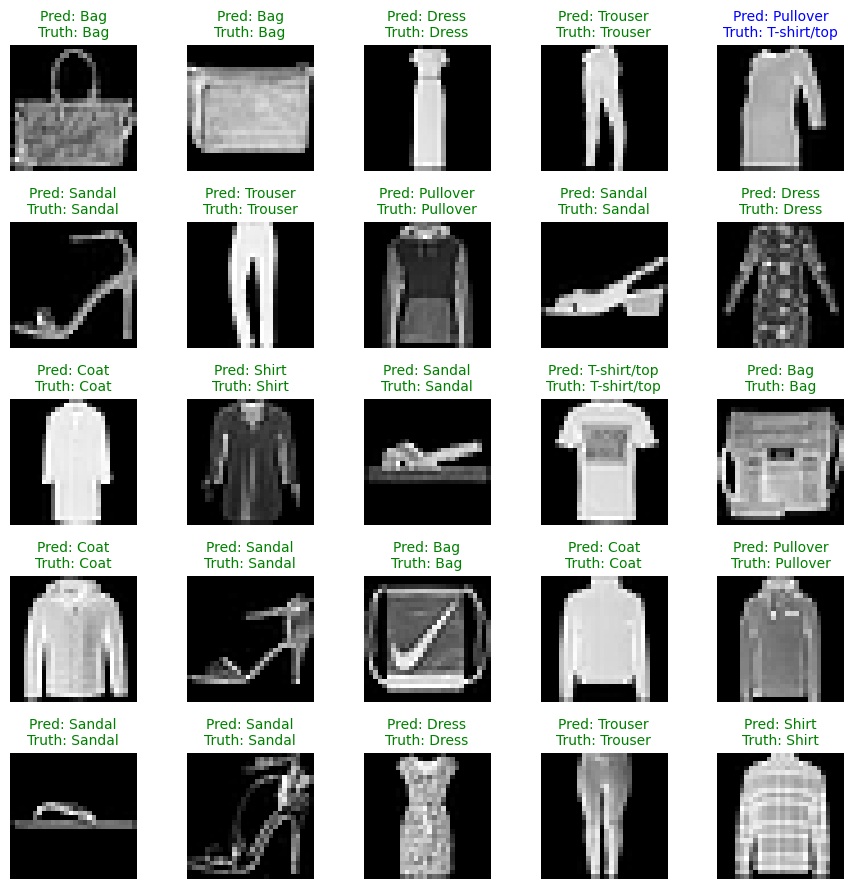

In [104]:
# display predicted label and true label for each test sample
plt.figure(figsize=(9, 9))
num_rows = 5
num_cols = 5
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(num_rows, num_cols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, not just the index)
    pred_label = class_names[pred_labels[i]]

    # Get the truth label (in text form, not just the index)
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label}\nTruth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="b") # blue text if wrong
    plt.axis(False)
plt.tight_layout()

In [106]:
# !pip install torchmetrics

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

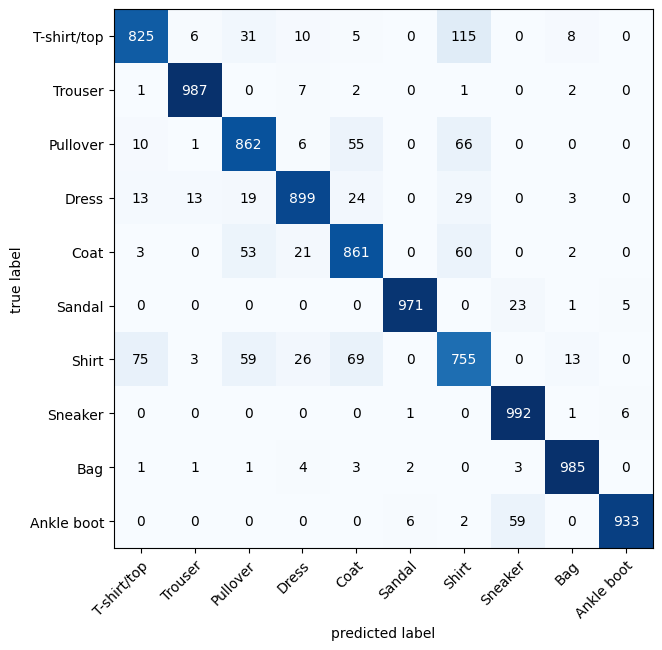

In [114]:
# confusian matrix

# inference on the entire testing dataset
from torchmetrics import ConfusionMatrix

y_preds = []
y_trues = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)

        y_logits = model(X)
        y_preds.append(y_logits.argmax(dim=1).cpu())
        y_trues.append(y.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_trues)

# construct confusian matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=y_true_tensor)

# plot the confusian matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7))


In [120]:
# print accuracy
accuracy = torch.sum(y_pred_tensor == y_true_tensor) / len(y_true_tensor)
print(f"Testing accuracy: {accuracy * 100:.2f}%")

Testing accuracy: 90.70%
